# Basic System

This notebook provides code for implementing a very simple machine learning system for named entity recognition.



In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import sys
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import utils
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from utils import calculate_metrix_from_output
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from ner_machine_learning import extract_embeddings_as_features_and_gold
from ner_machine_learning import extract_traditional_features_and_embeddings_plus_gold_labels
from ner_machine_learning import label_data_with_combined_features
from ner_machine_learning import extract_feature_values
import csv
import gensim
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle
from itertools import combinations
from skopt import BayesSearchCV
from scipy.stats import uniform
from skopt.space import Real

## 2.1. Load and inspect the data
**Suggestions:**
 - Download the following files form and place them in the folder "`./data/conll2003`":
   - `conll2003.train.conll`, `conll2003.test.conll`, `conll2003.dev.conll`


In [6]:
def extract_features_and_labels(trainingfile):
    """Takes as input the path to a conll file and returns the token, the POS tag and the NER label"""
    data = []
    pos_tag = []
    targets = []
    with open(trainingfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token = components[0]
                feature_dict = {'token':token}
                data.append(feature_dict)
                pos_tag.append(components[1])
                targets.append(components[-1])
    return data, pos_tag, targets

In [8]:
def extract_dict_gold(inputfile):
    """Takes as input the path to a conll file and returns a list of dictionaries
    with features for each token. Those features are the token itself, the POS tag,
    the capitalization type ('upper', 'lower', 'title', or 'other'), and the surrounding tokens."""   
    data = []
    with open(inputfile, 'r', encoding='utf8') as infile:
        lines = infile.readlines()
        for line_index, line in enumerate(lines):
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token = components[0] # token itself
                pos = components[1] # pos tag
                chunk = components[2] # syntax
                gold_label = components[-1] 
                if token.isupper(): #capitalization pattern
                    capitalization = 'uppercase'
                elif token.islower():
                    capitalization = 'lowercase'
                elif token.istitle():
                    capitalization = 'first_letter_capitalization'
                else:
                    capitalization = 'other'                
                if line_index > 0:  # if previous line
                    prev_line = lines[line_index-1].rstrip('\n')  # get previous line
                    if prev_line:  # if empty
                        prev_token = prev_line.split()[0] # get previous token
                    else:
                        prev_token = "START!!"  # no tokens before
                else:
                    prev_token = "START!!"  # no tokens before
                if line_index < len(lines) - 1:  # if next line
                    next_line = lines[line_index+1].rstrip('\n')  # get next line
                    if next_line:  # if empty
                        next_token = next_line.split()[0]  # get next token
                    else:
                        next_token = "END!!"  # no tokens after
                else:
                    next_token = "END!!"  # no tokens after
                feature_dict = {'Token': token, 'Pos': pos, 'Chunklabel': chunk, 
                                'Capitalization': capitalization, 'Prev_token': prev_token, 'Next_token': next_token,'Gold_label':gold_label}
                data.append(feature_dict)
    return data

In [10]:
def write_features_to_conll(train_features, outputfile):
    '''takes dict with features and writes them to conll file'''
    with open(outputfile, 'w', encoding='utf8') as outfile:
        for feature_dict in train_features:
            token = feature_dict['Token']
            pos = feature_dict['Pos']
            chunk = feature_dict['Chunklabel']
            capitalization = feature_dict['Capitalization']
            gold_label = feature_dict['Gold_label']
            prev_token = feature_dict['Prev_token']
            next_token = feature_dict['Next_token']
            line = f"{token}\t{pos}\t{chunk}\t{prev_token}\t{next_token}\t{capitalization}\t{gold_label}\n"
            outfile.write(line)

        outfile.write("\n")

In [12]:
def extract_features(inputfile):
    """Takes as input the path to a conll file and returns a list of dictionaries
    with features for each token. Those features are the token itself, the POS tag,
    the capitalization type ('upper', 'lower', 'title', or 'other'), and the surrounding tokens."""   
    data = []
    with open(inputfile, 'r', encoding='utf8') as infile:
        lines = infile.readlines()
        for line_index, line in enumerate(lines):
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token = components[0] # token itself
                pos = components[1] # pos tag
                chunk = components[2]
                pt = components[3]
                nt = components[4]
                capitalization = components[5]
                feature_dict = {'Token': token, 'Pos': pos, 'Chunklabel': chunk, 
                                'Capitalization': capitalization,'Prev_token': pt, 'Next_token':nt}
                data.append(feature_dict)
    return data

In [14]:
data_folder = "../../data/conll2003/"

train_file = data_folder + "conll2003.train.conll"
test_file = data_folder + "conll2003.test.conll"
dev_file = data_folder + "conll2003.dev.conll"

In [16]:
train_data, train_tags, train_targets = extract_features_and_labels(train_file)
list_tup_train = []
for dt, tags, target in zip(train_data, train_tags, train_targets):
    if target != 'O':
        list_tup_train.append((dt, tags, target))

In [17]:
dev_data, dev_tags, dev_targets = extract_features_and_labels(dev_file)
list_tup_dev = []
for dt, tags, target in zip(dev_data, dev_tags, dev_targets):
    if target != 'O':
        list_tup_dev.append((dt, tags, target))
# print(list_tup_dev)

In [20]:
test_data, test_tags, test_targets = extract_features_and_labels(test_file)
list_tup_test = []
for dt, tags, target in zip(test_data, test_tags, test_targets):
    if target != 'O':
        list_tup_test.append((dt, tags, target))
# print(list_tup_test)

In [22]:
our_train_features = extract_dict_gold(train_file)
all_train_outputfile = './all_our_train_features_file.conll'
all_our_train_features_conll = write_features_to_conll(our_train_features, all_train_outputfile)

In [23]:
our_dev_features = extract_dict_gold(dev_file)
all_dev_outputfile = './all_our_dev_features_file.conll'
all_our_dev_features_conll = write_features_to_conll(our_dev_features, all_dev_outputfile)

In [182]:
our_test_features = extract_dict_gold(test_file)
all_test_outputfile = './all_our_test_features_file.conll'
all_our_test_features_conll = write_features_to_conll(our_test_features, all_test_outputfile)

## 2.2. Data analysis: feature and label distributions


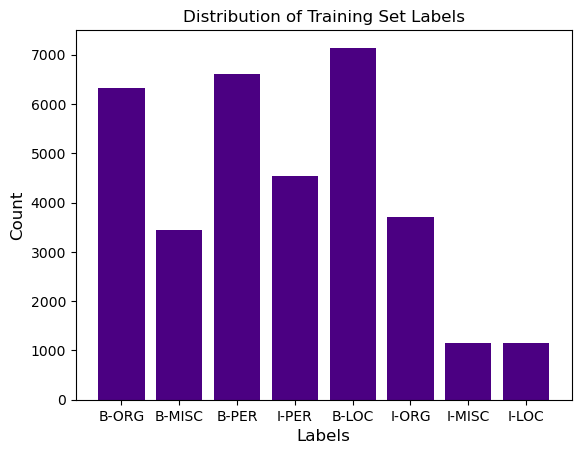

B-ORG: 6321
B-MISC: 3438
B-PER: 6600
I-PER: 4528
B-LOC: 7140
I-ORG: 3704
I-MISC: 1155
I-LOC: 1157


In [122]:
#Analysing the label distribution within the training set
filtered_train_targets = []
for target in train_targets:
    if target != 'O':
        filtered_train_targets.append(target)     
distribution_train_targets = Counter(filtered_train_targets)
plt.bar(distribution_train_targets.keys(), distribution_train_targets.values(),color='indigo')
plt.title('Distribution of Training Set Labels', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


for label, count in distribution_train_targets.items():
    print(f'{label}: {count}')

In [124]:
#Classifying the different named entities in seperate lists within the trainining set
train_per_list = []
train_loc_list = []
train_org_list = []
train_misc_list = []
for tuple in list_tup_train:
    if 'PER' in tuple[2]:
        train_per_list.append(tuple)
    if 'LOC' in tuple[2]:
        train_loc_list.append(tuple)
    if 'ORG' in tuple[2]:
        train_org_list.append(tuple)
    if 'MISC' in tuple[2]:
        train_misc_list.append(tuple)

In [126]:
#Analysing the frequency of the POS tags within the training set
train_pos_list_per = utils.most_common_pos(train_per_list)
print('Most common POS in person list: ', train_pos_list_per)
train_pos_list_loc = utils.most_common_pos(train_loc_list)
print('Most common POS in location list: ', train_pos_list_loc)
train_pos_list_org = utils.most_common_pos(train_org_list)
print('Most common POS in org list: ', train_pos_list_org)
train_pos_list_misc = utils.most_common_pos(train_misc_list)
print('Most common POS in miscellaneous entity list: ', train_pos_list_misc)

Most common POS in person list:  [('NNP', 10512), ('NN', 191), ('JJ', 95), ('NNPS', 86), ('NNS', 63), ('FW', 34), ('RB', 28), ('JJR', 19), ('VB', 19), ('VBG', 17), ('VBZ', 13), ('VBN', 9), ('DT', 7), ('VBD', 6), ('UH', 6), ('IN', 5), ('CD', 5), ('TO', 2), ('JJS', 2), ('MD', 2), ('(', 2), (')', 2), ('WRB', 1), ('WDT', 1), ('RP', 1)]
Most common POS in location list:  [('NNP', 7660), ('NN', 161), ('JJ', 110), ('NNPS', 65), ('RB', 39), ('VB', 37), ('NNS', 35), ('IN', 30), ('VBG', 29), ('VBN', 28), ('TO', 27), ('DT', 25), ('VBD', 8), ('JJR', 6), ('POS', 4), ('VBZ', 4), ('.', 4), ('CC', 3), ('WDT', 3), ('CD', 3), ('FW', 3), ('VBP', 3), ('UH', 2), ('(', 2), (')', 2), (',', 1), ('PRP', 1), ('PRP$', 1), ('RBS', 1)]
Most common POS in org list:  [('NNP', 8355), ('NN', 368), ('NNPS', 290), ('JJ', 183), ('NNS', 169), ('IN', 148), ('VB', 70), ('CC', 69), ('VBG', 57), ('POS', 40), ('DT', 38), ('RB', 31), ('FW', 30), ('CD', 24), ('VBN', 18), ('VBZ', 16), ('TO', 15), ('SYM', 15), (',', 13), ('UH', 11

In [128]:
#Looking into ortographic features such as capitalization patterns
print("PERSON -->", utils.capitalization_patterns(train_per_list))
print("LOCATION -->", utils.capitalization_patterns(train_loc_list))
print("ORGANIZATION -->", utils.capitalization_patterns(train_org_list))
print("MISCELLANEOUS ENTITY -->", utils.capitalization_patterns(train_misc_list))

PERSON --> {'uppercase': 410, 'lowercase': 65, 'first_letter_capitalization': 10543, 'other': 110}
LOCATION --> {'uppercase': 1747, 'lowercase': 35, 'first_letter_capitalization': 6495, 'other': 20}
ORGANIZATION --> {'uppercase': 1904, 'lowercase': 265, 'first_letter_capitalization': 7678, 'other': 178}
MISCELLANEOUS ENTITY --> {'uppercase': 819, 'lowercase': 71, 'first_letter_capitalization': 3468, 'other': 235}


In [130]:
#Exploring the most common words per category within the training set
train_per_common_words = utils.most_common_words(train_per_list)
print('Most common persons: ', train_per_common_words)
print()
train_loc_common_words = utils.most_common_words(train_loc_list)
print('Most common locations: ', train_loc_common_words)
print()
train_org_common_words = utils.most_common_words(train_org_list)
print('Most common organizations: ', train_org_common_words)
print()
train_misc_common_words = utils.most_common_words(train_misc_list)
print('Most common miscellaneous entities: ', train_misc_common_words)

Most common persons:  [('Clinton', 93), ('Mark', 58), ('Michael', 55), ('Paul', 51), ('John', 50), ('David', 50), ('Ahmed', 49), ('Arafat', 47), ('Martin', 47), ('Yeltsin', 47), ('M.', 46), ('Dole', 44), ('Lebed', 42), ('Akram', 37), ('Dutroux', 36), ('Wasim', 34), ('Thomas', 34), ('A.', 32), ('Peter', 31), ('Robert', 29), ('Waqar', 28), ('Younis', 28), ('Mushtaq', 28), ('Croft', 28), ('de', 26), ('Mullally', 26), ('Netanyahu', 25), ('Khan', 25), ('Bill', 25), ('Steve', 23), ('Alexander', 23), ('G.', 23), ('D.', 22), ('Sohail', 22), ('Alex', 22), ('Johnson', 22), ('Ian', 22), ('Jim', 21), ('Lewis', 21), ('Todd', 21), ('Richard', 21), ('Mother', 21), ('Teresa', 21), ('N.', 20), ('Medvedev', 20), ('Jose', 20), ('Scott', 19), ('Chris', 19), ('Sanchez', 19), ('R.', 19)]

Most common locations:  [('U.S.', 309), ('Germany', 142), ('Britain', 133), ('Australia', 130), ('England', 124), ('France', 122), ('Spain', 110), ('Italy', 98), ('New', 95), ('LONDON', 93), ('China', 91), ('Russia', 88), 

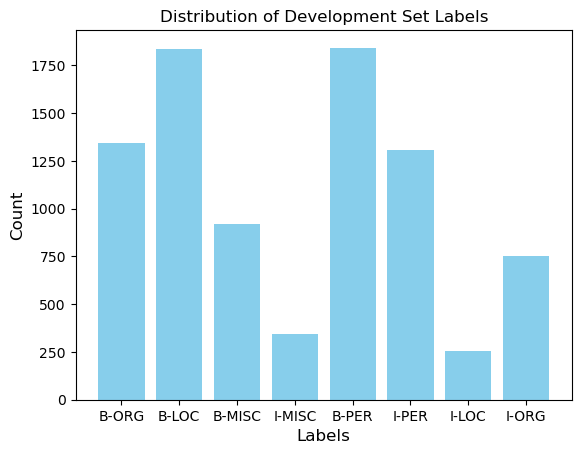

B-ORG: 1341
B-LOC: 1837
B-MISC: 922
I-MISC: 346
B-PER: 1842
I-PER: 1307
I-LOC: 257
I-ORG: 751


In [132]:
#Analysing the label distribution within the development set
filtered_dev_targets = []
for target in dev_targets:
    if target != 'O':
        filtered_dev_targets.append(target) 
distribution_dev_targets = Counter(filtered_dev_targets)
plt.bar(distribution_dev_targets.keys(), distribution_dev_targets.values(),color='skyblue')
plt.title('Distribution of Development Set Labels', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


for label, count in distribution_dev_targets.items():
    print(f'{label}: {count}')

In [134]:
#Classifying the different named entities in seperate lists within the development set
dev_per_list = []
dev_loc_list = []
dev_org_list = []
dev_misc_list = []
for tuple in list_tup_dev:
    if 'PER' in tuple[2]:
        dev_per_list.append(tuple)
    if 'LOC' in tuple[2]:
        dev_loc_list.append(tuple)
    if 'ORG' in tuple[2]:
        dev_org_list.append(tuple)
    if 'MISC' in tuple[2]:
        dev_misc_list.append(tuple)


In [136]:
#Analysing the frequency of the POS tags within the training set
dev_pos_list_per = utils.most_common_pos(dev_per_list)
print('Most common POS in person list: ', dev_pos_list_per)
dev_pos_list_loc = utils.most_common_pos(dev_loc_list)
print('Most common POS in location list: ', dev_pos_list_loc)
dev_pos_list_org = utils.most_common_pos(dev_org_list)
print('Most common POS in org list: ', dev_pos_list_org)
dev_pos_list_misc = utils.most_common_pos(dev_misc_list)
print('Most common POS in miscellaneous entity list: ', dev_pos_list_misc)

Most common POS in person list:  [('NNP', 2960), ('NN', 50), ('JJ', 36), ('NNPS', 25), ('NNS', 19), ('FW', 14), ('VBN', 6), ('RB', 6), ('"', 4), ('IN', 4), ('(', 4), (')', 4), ('PRP', 4), ('VB', 3), ('UH', 3), ('VBG', 2), ('MD', 2), ('VBP', 1), ('DT', 1), ('CD', 1)]
Most common POS in location list:  [('NNP', 1930), ('NN', 42), ('JJ', 37), ('VB', 14), ('RB', 12), ('IN', 11), ('VBG', 11), ('NNPS', 10), ('DT', 7), ('NNS', 7), ('POS', 3), ('TO', 3), ('CD', 3), ('JJR', 1), ('VBD', 1), ('PRP', 1), ('VBN', 1)]
Most common POS in org list:  [('NNP', 1679), ('NN', 91), ('NNPS', 66), ('IN', 38), ('JJ', 35), ('VB', 32), ('NNS', 24), ('CC', 22), ('RB', 18), ('POS', 16), ('VBG', 13), ('(', 13), (')', 13), ('DT', 8), ('PRP', 3), ('VBZ', 3), ('JJS', 3), ('VBN', 3), ('TO', 2), ('CD', 2), ('MD', 2), ('FW', 2), (',', 1), ('.', 1), ('NN|SYM', 1), ('UH', 1)]
Most common POS in miscellaneous entity list:  [('NNP', 622), ('JJ', 438), ('NNPS', 54), ('NN', 42), ('NNS', 21), ('CD', 21), ('IN', 19), ('DT', 13)

In [138]:
#Looking into ortographic features such as capitalization patterns within the development set
print("PERSON -->", utils.capitalization_patterns(dev_per_list))
print("LOCATION -->", utils.capitalization_patterns(dev_loc_list))
print("ORGANIZATION -->", utils.capitalization_patterns(dev_org_list))
print("MISCELLANEOUS ENTITY -->", utils.capitalization_patterns(dev_misc_list))

PERSON --> {'uppercase': 117, 'lowercase': 21, 'first_letter_capitalization': 2954, 'other': 57}
LOCATION --> {'uppercase': 477, 'lowercase': 10, 'first_letter_capitalization': 1593, 'other': 14}
ORGANIZATION --> {'uppercase': 371, 'lowercase': 63, 'first_letter_capitalization': 1599, 'other': 59}
MISCELLANEOUS ENTITY --> {'uppercase': 203, 'lowercase': 28, 'first_letter_capitalization': 976, 'other': 61}


In [140]:
#Exploring the most common words per category within the development set
dev_per_common_words = utils.most_common_words(dev_per_list)
print('Most common persons: ', dev_per_common_words)
print()
dev_loc_common_words = utils.most_common_words(dev_loc_list)
print('Most common locations: ', dev_loc_common_words)
print()
dev_org_common_words = utils.most_common_words(dev_org_list)
print('Most common organizations: ', dev_org_common_words)
print()
dev_misc_common_words = utils.most_common_words(dev_misc_list)
print('Most common miscellaneous entities: ', dev_misc_common_words)

Most common persons:  [('Lebed', 23), ('Wang', 23), ('Clinton', 20), ('Yeltsin', 19), ('Michael', 18), ('Peter', 14), ('Edberg', 14), ('Mark', 13), ('Paul', 13), ('David', 13), ('M.', 12), ('John', 12), ('Dole', 12), ('Suu', 12), ('Kyi', 12), ('Jansher', 11), ('Arafat', 11), ('Van', 11), ('Bernardin', 10), ('A.', 9), ('Washington', 9), ('Mike', 9), ('Ahmed', 9), ('Hollioake', 9), ('Mushtaq', 9), ('Joubert', 9), ('Jordan', 9), ('Tom', 8), ('J.', 8), ('Hill', 8), ('Henke', 8), ('Parnevik', 8), ('Silva', 8), ('Bailey', 8), ('James', 8), ('Lukashenko', 8), ('Johnson', 7), ('Martin', 7), ('D.', 7), ('S.', 7), ('Alan', 7), ('Roberto', 7), ('Anthony', 7), ('Alexander', 7), ('Thomas', 7), ('Andre', 7), ('Rios', 7), ('Tarango', 7), ('Bob', 7), ('Stewart', 7)]

Most common locations:  [('U.S.', 114), ('Germany', 47), ('Russia', 45), ('France', 37), ('England', 32), ('Australia', 29), ('Iraq', 29), ('Israel', 29), ('Chechnya', 28), ('China', 27), ('Britain', 24), ('LONDON', 23), ('Italy', 21), ('

## 2.3. Evaluation


In [143]:
# with open('../../data/sample_conll_data/sample_gt.conll', 'w') as outfile:
#         for token_dict, ner_label in zip(train_data[:345], train_targets[:345]):
#             token = token_dict['token']
#             outfile.write(f"{token}\t{ner_label}\n")
#         outfile.write("\n")

# with open('../../data/sample_conll_data/sample_pred.conll', 'w') as outfile:
#         for token_dict, label in zip(train_data[:345], train_targets[:345]):
#             token = token_dict['token']
#             outfile.write(f"{token}\t{label}\n")
#         outfile.write("\n")

Precision: 0.9652173913043478
Recall: 0.9652173913043478
F-score: 0.9652173913043478
Report: 
               precision    recall  f1-score   support

       B-LOC      0.778     1.000     0.875         7
      B-MISC      0.778     0.700     0.737        10
       B-ORG      0.600     0.667     0.632         9
       B-PER      0.875     0.778     0.824         9
      I-MISC      0.000     0.000     0.000         2
       I-ORG      0.667     0.667     0.667         3
       I-PER      0.778     0.875     0.824         8
           O      1.000     1.000     1.000       297

    accuracy                          0.965       345
   macro avg      0.684     0.711     0.695       345
weighted avg      0.962     0.965     0.963       345

Confusion Matrix:


/home/elisabetta/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


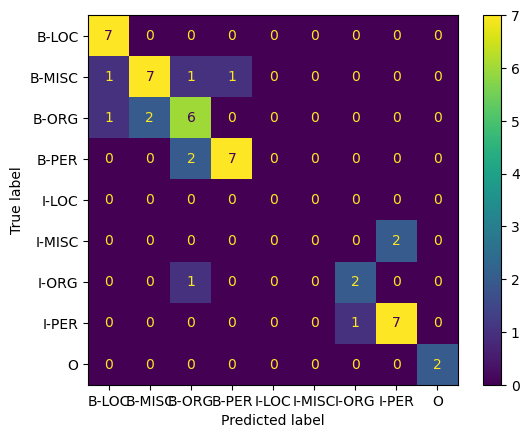

In [145]:
ground_truth_file = './sample_conll_data/sample_gt.conll'
prediction_sample_file = './sample_conll_data/sample_pred.conll'
labels = ['B-LOC','B-MISC','B-ORG','B-PER','I-LOC','I-MISC','I-ORG','I-PER','O']
precision, recall, f_score, cm, report = utils.calculate_metrics(ground_truth_file, prediction_sample_file)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-score: {f_score}")  
print(f"Report: \n {report}")
print("Confusion Matrix:")
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot()

## 2.4. Train and evaluate basic NERC system


In [189]:
# I modified the function so that it could be flexible to different models
def create_classifier(train_file, train_targets, modelname = 'logreg', embedded = False, 
                      language_model = None):
    """If 'embedded' is False, it trains either a logistic regression, or Naive Bayes, or SVM classifier 
    by taking as inputs a conll file from which it extracts selected features as a dictionary, and a list of 
    labels corresponding to each instance.It returns a trained logistic regression/naive bayes/SVM model
    and the vectoriser fitted on the selected features, which will be used for predictions.
    If 'embedded' is True, it takes as imput a conll file from which it extracts features and labels, and
    a 'language_model'. it returns the trained logistic regression model fitted on word embeddings including one-hot-vectors for
    for traditional features, such as POS tags,chunk labels and capitalization. 
    """
    
    if embedded == True:
        feature_vectors, vec, gold_labels = extract_traditional_features_and_embeddings_plus_gold_labels(train_file, language_model)
        model = LinearSVC()
        model.fit(feature_vectors, gold_labels)
        return model, vec
    
    else:
        train_features = extract_features(train_file)
        vec = DictVectorizer()
        features_vectorized = vec.fit_transform(train_features)
        
        if modelname == 'logreg':
            model = LogisticRegression(max_iter=1000)
            model.fit(features_vectorized, train_targets)
            return model,vec
            
        elif modelname == 'NB':
            model = MultinomialNB()
            param_grid = {'alpha':[0.01, 0.05, 0.08]}
            model.fit(features_vectorized, train_targets)
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
            grid_search.fit(features_vectorized, train_targets)
            model = grid_search.best_estimator_
            return model, vec
        
        elif modelname == 'SVM':
            param_space = {'C': Real(0.1, 50, 'uniform')}
            print('Searching parameters...')
            bayes_search = BayesSearchCV(
                LinearSVC(max_iter=5000, tol=0.01),
                param_space,
                n_iter=10,
                cv=5,
                random_state=42
            )
            bayes_search.fit(features_vectorized, train_targets)
            print("Best parameters for SVC:", bayes_search.best_params_)
            print("Best score during tuning:", bayes_search.best_score_)
            
            best_model = bayes_search.best_estimator_
            return best_model, vec

In [191]:
def classify_data(model, inputdata, outputfile, vec, embedded = False, language_model = None):
    """Taken an inputdata, an output path, a logistic regression model, a vectorizer,
    and a language_model(if needed). The function extracts features from the input and writes each 
    line to the output adding the predicted labels"""
    if embedded == False:
        features = extract_features(inputdata)
        features = vec.transform(features)
        predictions = model.predict(features)
          
    if embedded == True:
        predictions, gold_labels = label_data_with_combined_features(inputdata, model, vec, language_model)
    
    outfile = open(outputfile, 'w')
    counter = 0
    for line in open(inputdata, 'r'):
        if len(line.rstrip('\n').split()) > 0:
            outfile.write(line.rstrip('\n') + '\t' + predictions[counter] + '\n')
            counter += 1
    outfile.close()

              precision    recall  f1-score   support

       B-LOC      0.868     0.817     0.842      1837
      B-MISC      0.895     0.784     0.836       922
       B-ORG      0.802     0.738     0.769      1341
       B-PER      0.867     0.892     0.879      1842
       I-LOC      0.907     0.724     0.805       257
      I-MISC      0.894     0.633     0.741       346
       I-ORG      0.824     0.710     0.763       751
       I-PER      0.848     0.938     0.891      1307
           O      0.988     0.997     0.992     42759

    accuracy                          0.967     51362
   macro avg      0.877     0.804     0.835     51362
weighted avg      0.966     0.967     0.966     51362



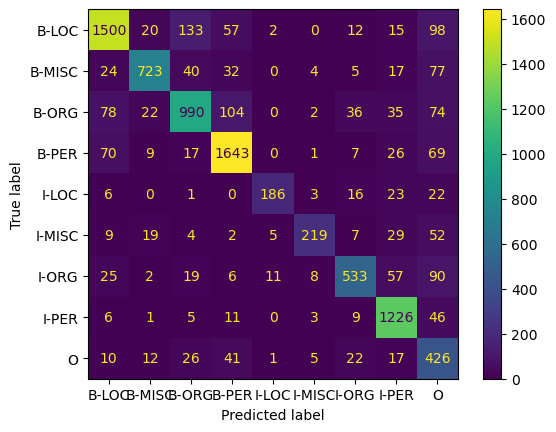

In [126]:
# training the classifier with the 'logreg' model
class_model, class_vec = create_classifier(all_train_outputfile, train_targets,'logreg')
dev_outputfile = './new_conll_file.conll'
classified_data = classify_data(class_model,all_dev_outputfile, dev_outputfile,vec = class_vec)
calculate_metrix_from_output(dev_outputfile)

In [160]:
def error_analysis(output_gold_pred_file):
    """takes as input the file created throught the function classify_data, compares the last two columns of the file.
    In case withun the same row, the values of the two columns are not equivalent, they are collected and saved in a list of strings
    that presents the line and token to which the misclassification refers."""
    all_errors = []
    with open(output_gold_pred_file, 'r', encoding='utf8') as infile:
            lines = infile.readlines()
            for line_index, line in enumerate(lines):
                components = line.rstrip('\n').split()
                if len(components) > 0:
                    token = components[0]
                    gold_label = components[-2]
                    prediction = components[-1]
                    if gold_label != prediction:
                        all_errors.append(f'{line_index} > {token}: {gold_label}, {prediction}')
    return all_errors           

In [168]:
lr_error = error_analysis(dev_outputfile)
print(f'Number of misclassifications : {len(lr_error)}')
for error in lr_error:
    print(error)

Number of misclassifications : 1717
6 > TOP: O, B-LOC
13 > West: B-MISC, B-LOC
14 > Indian: I-MISC, I-LOC
27 > Somerset: B-ORG, B-PER
61 > Essex: B-ORG, I-PER
87 > Somerset: B-ORG, I-PER
97 > Road: I-LOC, I-PER
127 > Somerset: B-ORG, B-PER
177 > Hussain: B-PER, O
224 > Such: B-PER, O
370 > Derbyshire: B-ORG, B-LOC
421 > ex-England: B-MISC, O
463 > Leicester: B-LOC, O
467 > Somerset: B-ORG, B-PER
495 > Chester-le-Street: B-LOC, O
511 > Blenkiron: I-PER, B-PER
525 > Tunbridge: B-LOC, B-PER
526 > Wells: I-LOC, O
545 > The: B-LOC, O
553 > 429-7: O, I-PER
578 > Hove: B-LOC, O
597 > 197-8: O, I-PER
628 > Chesterfield: B-LOC, O
635 > Derbyshire: B-ORG, B-PER
642 > T.O'Gorman: B-PER, B-MISC
652 > Moody: I-PER, B-ORG
655 > Bristol: B-LOC, O
684 > ASHES: B-MISC, O
693 > Ashes: B-MISC, B-ORG
713 > and: I-ORG, O
754 > British: B-ORG, B-MISC
765 > Counties: I-ORG, I-PER
769 > Tour: O, B-MISC
775 > Arrive: O, I-PER
780 > Practice: O, I-PER
783 > 's: I-LOC, O
788 > of: I-ORG, O
789 > Norfolk: I-ORG, 

In [132]:
#loading language model
language_model = gensim.models.KeyedVectors.load_word2vec_format('../../models/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [134]:
# training the classifier with word embeddings
emb_model, emb_vectorizer = create_classifier(all_train_outputfile, train_targets,'logreg',embedded = True, language_model=language_model)

              precision    recall  f1-score   support

       B-LOC      0.888     0.895     0.892      1837
      B-MISC      0.866     0.824     0.844       922
       B-ORG      0.833     0.802     0.817      1341
       B-PER      0.909     0.933     0.921      1842
       I-LOC      0.843     0.794     0.818       257
      I-MISC      0.776     0.630     0.695       346
       I-ORG      0.832     0.706     0.764       751
       I-PER      0.961     0.945     0.953      1307
           O      0.991     0.996     0.993     42759

    accuracy                          0.973     51362
   macro avg      0.878     0.836     0.855     51362
weighted avg      0.972     0.973     0.973     51362



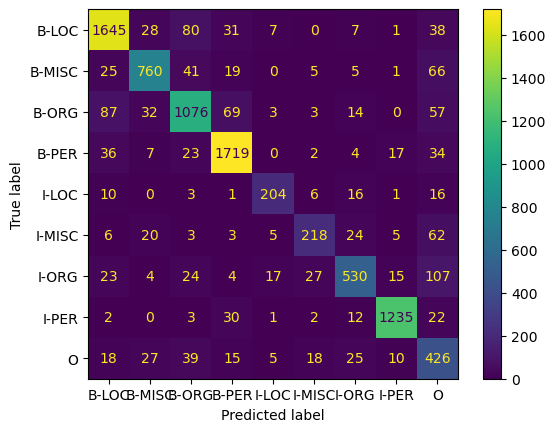

In [136]:
dev_emb_outputfile = './emb_conll_file.conll'
classified_data = classify_data(emb_model,all_dev_outputfile, dev_emb_outputfile, emb_vectorizer, embedded = True, language_model = language_model)
calculate_metrix_from_output(dev_emb_outputfile)

In [172]:
emb_errors = error_analysis(dev_emb_outputfile)
print(f'Number of misclassifications : {len(emb_errors)}')
for error in emb_errors:
    print(error)

Number of misclassifications : 1373
2 > LEICESTERSHIRE: B-ORG, O
13 > West: B-MISC, B-LOC
14 > Indian: I-MISC, I-LOC
72 > Kent: B-ORG, B-PER
87 > Somerset: B-ORG, I-LOC
163 > Such: I-PER, O
224 > Such: B-PER, O
398 > Kent: B-ORG, B-PER
421 > ex-England: B-MISC, O
433 > Kent: B-ORG, B-PER
463 > Leicester: B-LOC, B-ORG
495 > Chester-le-Street: B-LOC, O
525 > Tunbridge: B-LOC, B-PER
540 > Kent: B-ORG, B-PER
545 > The: B-LOC, O
578 > Hove: B-LOC, O
628 > Chesterfield: B-LOC, B-ORG
652 > Moody: I-PER, B-ORG
684 > ASHES: B-MISC, O
713 > and: I-ORG, O
714 > County: I-ORG, B-ORG
754 > British: B-ORG, B-MISC
755 > Universities: I-ORG, O
764 > Minor: B-ORG, B-LOC
765 > Counties: I-ORG, I-MISC
783 > 's: I-LOC, O
788 > of: I-ORG, O
789 > Norfolk: I-ORG, B-LOC
790 > 's: I-ORG, O
791 > XI: I-ORG, O
839 > 's: I-LOC, O
905 > 's: I-LOC, O
910 > British: B-ORG, B-MISC
911 > Universities: I-ORG, O
937 > Manchester: B-LOC, B-ORG
943 > Counties: I-ORG, I-MISC
948 > Scotland: B-LOC, B-ORG
1239 > 96: I-MISC,

In [116]:
#training the classifier with SVC
svc_class_model, svc_class_vec = create_classifier(all_train_outputfile, train_targets,'SVM')


Searching parameters...
Best parameters for SVC: OrderedDict({'C': 40.63855981903243})
Best score during tuning: 0.9690798200212736


              precision    recall  f1-score   support

       B-LOC      0.909     0.876     0.892      1837
      B-MISC      0.898     0.826     0.861       922
       B-ORG      0.839     0.803     0.821      1341
       B-PER      0.902     0.916     0.909      1842
       I-LOC      0.885     0.809     0.846       257
      I-MISC      0.851     0.676     0.754       346
       I-ORG      0.860     0.744     0.798       751
       I-PER      0.895     0.959     0.926      1307
           O      0.991     0.997     0.994     42759

    accuracy                          0.974     51362
   macro avg      0.892     0.845     0.867     51362
weighted avg      0.973     0.974     0.973     51362



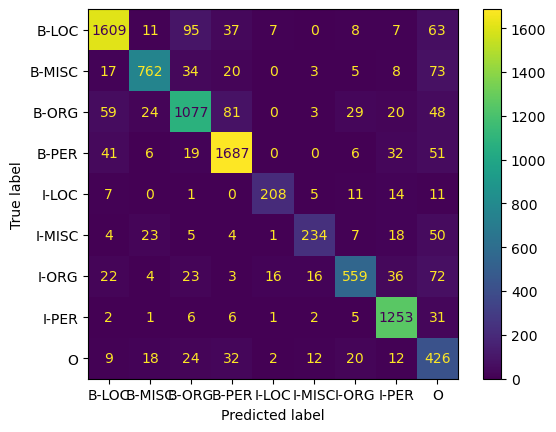

In [118]:
svc_dev_outputfile = './new_conll_file_svc.conll'
svc_classified_data = classify_data(svc_class_model, all_dev_outputfile, svc_dev_outputfile, vec = svc_class_vec)
calculate_metrix_from_output(svc_dev_outputfile)

In [174]:
svc_errors = error_analysis(svc_dev_outputfile)
print(f'Number of misclassifications : {len(svc_errors)}')
for error in svc_errors:
    print(error)

Number of misclassifications : 1343
13 > West: B-MISC, B-LOC
87 > Somerset: B-ORG, I-PER
224 > Such: B-PER, O
251 > the: O, B-LOC
252 > Oval: B-LOC, I-LOC
421 > ex-England: B-MISC, O
424 > Martin: B-PER, I-PER
597 > 197-8: O, I-PER
652 > Moody: I-PER, B-ORG
653 > 6-82: O, I-ORG
684 > ASHES: B-MISC, O
693 > Ashes: B-MISC, B-ORG
713 > and: I-ORG, O
754 > British: B-ORG, B-MISC
765 > Counties: I-ORG, I-PER
769 > Tour: O, B-MISC
775 > Arrive: O, I-PER
788 > of: I-ORG, O
789 > Norfolk: I-ORG, B-PER
790 > 's: I-ORG, O
791 > XI: I-ORG, B-ORG
810 > First: O, B-MISC
848 > Sussex: B-ORG, B-LOC
850 > Surrey: B-ORG, I-PER
869 > First: O, I-ORG
937 > Manchester: B-LOC, B-ORG
943 > Counties: I-ORG, B-ORG
967 > Fourth: O, I-PER
984 > Fifth: O, I-PER
1003 > Sixth: O, I-PER
1018 > ENGLAND: B-LOC, O
1082 > Platt: B-PER, B-LOC
1242 > Teddy: B-PER, I-PER
1274 > BELGRADE: B-LOC, O
1304 > LITHUANIA: B-LOC, B-ORG
1309 > BUCHAREST: B-LOC, O
1355 > ROTOR: B-ORG, O
1357 > LOCKED: O, B-ORG
1360 > VOLGOGRAD: B-LO

              precision    recall  f1-score   support

       B-LOC      0.721     0.903     0.801      1837
      B-MISC      0.758     0.815     0.785       922
       B-ORG      0.694     0.790     0.738      1341
       B-PER      0.916     0.861     0.888      1842
       I-LOC      0.756     0.747     0.751       257
      I-MISC      0.745     0.616     0.674       346
       I-ORG      0.784     0.728     0.755       751
       I-PER      0.920     0.946     0.933      1307
           O      0.993     0.980     0.986     42759

    accuracy                          0.957     51362
   macro avg      0.809     0.821     0.812     51362
weighted avg      0.960     0.957     0.958     51362



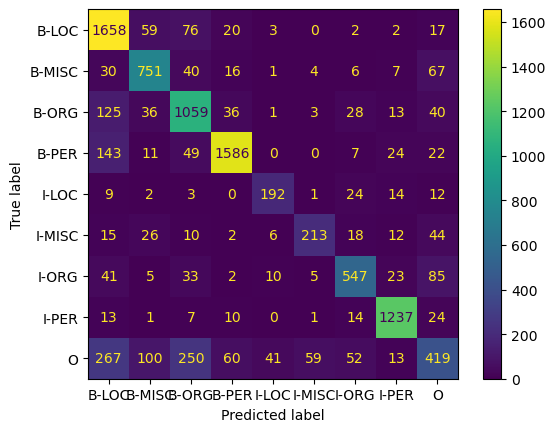

In [193]:
# training the classifier with the 'NB' model
nb_class_model, nb_class_vec = create_classifier(all_train_outputfile, train_targets,'NB')
nb_dev_outputfile = './new_conll_file_nb.conll'
nb_classified_data = classify_data(nb_class_model, all_dev_outputfile, nb_dev_outputfile, vec = nb_class_vec)
calculate_metrix_from_output(nb_dev_outputfile)

In [176]:
nb_errors = error_analysis(nb_dev_outputfile)
print(f'Number of misclassifications : {len(nb_errors)}')
for error in nb_errors:
    print(error)

Number of misclassifications : 2202
0 > CRICKET: O, B-LOC
2 > LEICESTERSHIRE: B-ORG, B-LOC
3 > TAKE: O, I-LOC
5 > AT: O, B-ORG
6 > TOP: O, B-LOC
7 > AFTER: O, I-LOC
8 > INNINGS: O, B-MISC
13 > West: B-MISC, B-LOC
87 > Somerset: B-ORG, I-PER
97 > Road: I-LOC, I-PER
199 > Essex: B-ORG, B-LOC
252 > Oval: B-LOC, B-MISC
370 > Derbyshire: B-ORG, B-LOC
421 > ex-England: B-MISC, O
440 > CRICKET: O, B-LOC
495 > Chester-le-Street: B-LOC, O
518 > S.: B-PER, B-LOC
597 > 197-8: O, I-PER
599 > W.: B-PER, B-LOC
642 > T.O'Gorman: B-PER, O
655 > Bristol: B-LOC, B-ORG
681 > CRICKET: O, B-LOC
684 > ASHES: B-MISC, O
685 > INTINERARY: O, B-LOC
693 > Ashes: B-MISC, B-LOC
712 > Test: B-ORG, B-MISC
713 > and: I-ORG, O
754 > British: B-ORG, B-MISC
765 > Counties: I-ORG, I-PER
769 > Tour: O, B-MISC
772 > May: O, B-ORG
773 > May: O, B-ORG
775 > Arrive: O, B-ORG
778 > May: O, B-ORG
780 > Practice: O, B-ORG
783 > 's: I-LOC, O
784 > May: O, B-ORG
788 > of: I-ORG, O
789 > Norfolk: I-ORG, B-LOC
790 > 's: I-ORG, O
796

In [85]:
# Feature ablation for Logistic Regression
all_features = ['Token','Pos','Chunklabel','Capitalization','Prev_token','Next_token']
from itertools import combinations

def feature_ablation(train_file, dev_file, all_features):
    score = 0
    feat = []
    for r in range(1, len(all_features) + 1):
        for selected_features in combinations(all_features, r):

            selected_features = list(selected_features)
            
            print(f"\033[1mTesting features: {selected_features}\033[0m")

            train_features = extract_features(train_file)
            dev_features = extract_features(dev_file)
            
            train_features = [
                {feature: feature_dict[feature] for feature in selected_features if feature in feature_dict}
                for feature_dict in train_features
            ]
            dev_features = [
                {feature: feature_dict[feature] for feature in selected_features if feature in feature_dict}
                for feature_dict in dev_features
            ]

            train_data = extract_dict_gold(train_file)
            train_labels = [dic['Gold_label'] for dic in train_data]
            dev_data = extract_dict_gold(dev_file)
            dev_labels = [dic['Gold_label'] for dic in dev_data]
            
            vec = DictVectorizer()

            train_features = vec.fit_transform(train_features)
            dev_features = vec.transform(dev_features)

            #Modify which model you want to use here
            model = LogisticRegression(max_iter=1000)
            model.fit(train_features, train_labels)
            
            predictions = model.predict(dev_features)

            f1 = sklearn.metrics.f1_score(dev_labels, predictions, average='macro', zero_division=0)

            print(f1)
            if f1> score:
                score = f1
                feat = selected_features

    return score,feat

lr_score,features = feature_ablation('all_our_train_features_file.conll', 'all_our_dev_features_file.conll', all_features)

Testing features: ['Token']
0.6392095669980818
Testing features: ['Pos']
0.1527490383508401
Testing features: ['Chunklabel']
0.10095515347265754
Testing features: ['Capitalization']
0.10095515347265754
Testing features: ['Prev_token']
0.3829459558341866
Testing features: ['Next_token']
0.2877302700016776
Testing features: ['Token', 'Pos']
0.6876269385133504
Testing features: ['Token', 'Chunklabel']
0.6755622979007696
Testing features: ['Token', 'Capitalization']
0.6934881033825104
Testing features: ['Token', 'Prev_token']
0.7648285705198055
Testing features: ['Token', 'Next_token']
0.7006715669393828
Testing features: ['Pos', 'Chunklabel']
0.22056748680105867
Testing features: ['Pos', 'Capitalization']
0.21474952069982983
Testing features: ['Pos', 'Prev_token']
0.5640257506849324
Testing features: ['Pos', 'Next_token']
0.43825088386846534
Testing features: ['Chunklabel', 'Capitalization']
0.15651788028461405
Testing features: ['Chunklabel', 'Prev_token']
0.4147317453358975
Testing feat

In [86]:
# Feature ablation for Naive Bayes
all_features = ['Token','Pos','Chunklabel','Capitalization','Prev_token','Next_token']
from itertools import combinations

def feature_ablation(train_file, dev_file, all_features):
    score = 0
    feat = []
    for r in range(1, len(all_features) + 1):
        for selected_features in combinations(all_features, r):
            selected_features = list(selected_features)
            
            print(f"\033[1mTesting features: {selected_features}\033[0m")

            train_features = extract_features(train_file)
            dev_features = extract_features(dev_file)
            
            train_features = [
                {feature: feature_dict[feature] for feature in selected_features if feature in feature_dict}
                for feature_dict in train_features
            ]
            dev_features = [
                {feature: feature_dict[feature] for feature in selected_features if feature in feature_dict}
                for feature_dict in dev_features
            ]

            train_data = extract_dict_gold(train_file)
            train_labels = [dic['Gold_label'] for dic in train_data]
            dev_data = extract_dict_gold(dev_file)
            dev_labels = [dic['Gold_label'] for dic in dev_data]
            
            vec = DictVectorizer()

            train_features = vec.fit_transform(train_features)
            dev_features = vec.transform(dev_features)

            #Modify which model you want to use here
            model = MultinomialNB() #this specific Naive Bayes model takes sparse vectors
            param_grid = {'alpha':[0.01, 0.05, 0.08],'force_alpha':[False], 'fit_prior':[True], 'class_prior':[None]}
            model.fit(train_features, train_labels)
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
            grid_search.fit(train_features, train_labels)
            model = grid_search.best_estimator_
           
            predictions = model.predict(dev_features)

            f1 = sklearn.metrics.f1_score(dev_labels, predictions, average='macro', zero_division=0)

            print(f1)
            if f1> score:
                score = f1
                feat = selected_features

    return score,feat

nb_score,features = feature_ablation('all_our_train_features_file.conll', 'all_our_dev_features_file.conll', all_features)

Testing features: ['Token']
0.707056730824906
Testing features: ['Pos']
0.15291588966073233
Testing features: ['Chunklabel']
0.10095515347265754
Testing features: ['Capitalization']
0.10095515347265754
Testing features: ['Prev_token']
0.4356556970213602
Testing features: ['Next_token']
0.3457393458312985
Testing features: ['Token', 'Pos']
0.694916601098207
Testing features: ['Token', 'Chunklabel']
0.7353356681235709
Testing features: ['Token', 'Capitalization']
0.7048874674881951
Testing features: ['Token', 'Prev_token']
0.8018034684964057
Testing features: ['Token', 'Next_token']
0.7252679065858365
Testing features: ['Pos', 'Chunklabel']
0.22090215540409924
Testing features: ['Pos', 'Capitalization']
0.24287091011758408
Testing features: ['Pos', 'Prev_token']
0.5846310276878222
Testing features: ['Pos', 'Next_token']
0.4401339606992709
Testing features: ['Chunklabel', 'Capitalization']
0.2005461914257666
Testing features: ['Chunklabel', 'Prev_token']
0.4608241371817845
Testing feature

### 2.4.2 Convert to a python file:

In [ ]:
def main(argv=None):

    if argv is None:
        argv = sys.argv
        
    
    trainingfile = argv[1]
    inputfile = argv[2]
    outputfile = argv[3]
    
    training_features, gold_labels = extract_features_and_labels(trainingfile)
    ml_model, vec = create_classifier(training_features, gold_labels)
    classify_data(ml_model, vec, inputfile, outputfile)

 
if __name__ == '__main__':
    main()


In [ ]:
args = ['python']
main(args)